In [1]:
# 기본 라이브러리
import numpy as np
import pandas as pd
import seaborn as sns

# 그래프 라이브러리
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib_inline.backend_inline

# 기본 설정 

matplotlib_inline.backend_inline.set_matplotlib_formats("png2x")
mpl.style.use("seaborn-v0_8")
mpl.rcParams.update({"figure.constrained_layout.use": True})
sns.set_context("paper") 
sns.set_palette("Set2") 
sns.set_style("whitegrid") 

plt.rc("font", family = "Malgun Gothic")
plt.rcParams["axes.unicode_minus"] = False

In [4]:
# 기본 작업 경로 설정
import os
notebook_path = os.path.abspath("../code/2_YOLO_finetunning.ipynb")
notebook_dir = os.path.dirname(notebook_path)
os.chdir(notebook_dir)

# 현재 작업 디렉토리 출력
print("Current working directory: ", os.getcwd())

Current working directory:  c:\Users\DA317\Desktop\Special course_Lee\240820(project)\project_3_git\code


In [7]:
import json

def openjson(path):

    with open(path, encoding="cp949") as f:
        data = json.load(f)
    return data

trainjsons = []
testjsons  = []
validjsons = []

trainjsons.extend([i for i in openjson('../data/image_data/train/label/train/train_anger.json')])
trainjsons.extend([i for i in openjson('../data/image_data/train/label/train/train_happy.json')])
trainjsons.extend([i for i in openjson('../data/image_data/train/label/train/train_panic.json')])
trainjsons.extend([i for i in openjson('../data/image_data/train/label/train/train_sadness.json')])

validjsons.extend([i for i in openjson('../data/image_data/train/label/val/val_anger.json')])
validjsons.extend([i for i in openjson('../data/image_data/train/label/val/val_happy.json')])
validjsons.extend([i for i in openjson('../data/image_data/train/label/val/val_panic.json')])
validjsons.extend([i for i in openjson('../data/image_data/train/label/val/val_sadness.json')])

testjsons.extend([i for i in openjson('../data/image_data/test/label/test_anger.json')])
testjsons.extend([i for i in openjson('../data/image_data/test/label/test_happy.json')])
testjsons.extend([i for i in openjson('../data/image_data/test/label/test_panic.json')])
testjsons.extend([i for i in openjson('../data/image_data/test/label/test_sadness.json')])

In [8]:
train_directory_path = '../data/image_data/train/img/train/'
valid_directory_path = '../data/image_data/train/img/val/'
test_directory_path = '../data/image_data/test/image/'


In [9]:
import os

def find_images(root_dir):
    # 이미지 확장자 목록
    image_extensions = {'.jpg', '.jpeg', '.png', '.gif', '.bmp'}
    
    image_files = []
    
    for root, dirs, files in os.walk(root_dir):
        for file in files:
            if os.path.splitext(file)[1].lower() in image_extensions:
                image_files.append(os.path.join(root, file))
    
    return image_files

paths_train = find_images(train_directory_path)
paths_valid = find_images(valid_directory_path)
paths_test = find_images(test_directory_path)

### yolo v10 의 어노테이션 이해
- yaml 파일 이해
    data.yaml
    
    ```text
    train: ../train/images
    val: ../valid/images

    nc: 3
    names: ['head', 'helmet', 'person']
    ```

- txt 파일
    
    ```class_id center_x center_y width height```
    ```text
    1 0.617 0.3594420600858369 0.114 0.17381974248927037
    1 0.094 0.38626609442060084 0.156 0.23605150214592274
    1 0.295 0.3959227467811159 0.13 0.19527896995708155
    ```

In [10]:
# train 어노테이션 만들기 포 욜로10
import cv2
import os

# 클래스 이름을 클래스 ID로 매핑하는 딕셔너리
class_names = ['anger', 'sad', 'panic', 'happy']
class_to_id = {name: idx for idx, name in enumerate(class_names)}

def convert_bbox_to_yolo_format(image_size, bbox):
    """
    바운딩 박스를 YOLO 형식으로 변환.
    :param image_size: (width, height) 이미지 크기
    :param bbox: {'minX': float, 'minY': float, 'maxX': float, 'maxY': float} 바운딩 박스 좌표
    :return: (x_center, y_center, width, height) YOLO 형식의 바운딩 박스
    """
    dw = 1.0 / image_size[0]
    dh = 1.0 / image_size[1]
    x_center = (bbox['minX'] + bbox['maxX']) / 2.0
    y_center = (bbox['minY'] + bbox['maxY']) / 2.0
    width = bbox['maxX'] - bbox['minX']
    height = bbox['maxY'] - bbox['minY']
    
    # YOLO 형식에 맞게 좌표를 정규화
    x_center = x_center * dw
    y_center = y_center * dh
    width = width * dw
    height = height * dh
    
    return (x_center, y_center, width, height)

def save_annotations(json_data, output_dir, image_size):
    """
    이미지를 yolo 에 맞게
    """
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    for item in json_data:
        image_file = item['filename']
        image_name, _ = os.path.splitext(image_file)
        txt_file_path = os.path.join(output_dir, f"{image_name}.txt")
        
        with open(txt_file_path, 'w') as f:
            # Iterate over annotations (A, B, C)
            annot = item.get('annot_A')
            print(annot)
            if annot:
                bbox = annot['boxes']
                print(bbox)
                face_exp = item['faceExp_uploader']
                print(face_exp)
                class_id = class_to_id.get(face_exp, -1)
                if class_id == -1:
                    class_id = 3
                print(class_id)
                if class_id != -1:
                    yolo_bbox = convert_bbox_to_yolo_format(image_size, bbox)
                    print(yolo_bbox)
                    f.write(f"{class_id} {' '.join(map(str, yolo_bbox))}\n")
                    print(f"{class_id} {' '.join(map(str, yolo_bbox))}\n")


In [11]:
output_directory = '../data/yolo_data/./train/'

for i in paths_train:
    name_of_file = (i.split('/')[-1].split('.')[0])
    for j in trainjsons:
        if name_of_file in j['filename']:

            # Check if annotation file already exists before saving
            image_file = j['filename']
            image_name, _ = os.path.splitext(image_file)
            txt_file_path = os.path.join(output_directory, f"{image_name}.txt")
            
            if not os.path.exists(txt_file_path):
                image = cv2.imread(i)
                h, w, _ = image.shape
                # 상대 위치로 결정되기 때문에 파일 크기가 필요하다
                image_size = (w, h)
                print(name_of_file)
                print(image_size)
                print(j['annot_A']['boxes'])
                save_annotations([j], output_directory, image_size)
                print('')
            else:
                print(f"Annotation file already exists: {txt_file_path}")


In [12]:
output_directory = '../data/yolo_data/./val/'

for i in paths_valid:
    name_of_file = (i.split('/')[-1].split('.')[0])
    for j in validjsons:
        if name_of_file in j['filename']:

            # Check if annotation file already exists before saving
            image_file = j['filename']
            image_name, _ = os.path.splitext(image_file)
            txt_file_path = os.path.join(output_directory, f"{image_name}.txt")
            
            if not os.path.exists(txt_file_path):
                image = cv2.imread(i)
                h, w, _ = image.shape
                # 상대 위치로 결정되기 때문에 파일 크기가 필요하다
                image_size = (w, h)
                print(name_of_file)
                print(image_size)
                print(j['annot_A']['boxes'])
                save_annotations([j], output_directory, image_size)
                print('')
            else:
                print(f"Annotation file already exists: {txt_file_path}")


[[[168 173 174]
  [167 172 173]
  [164 169 170]
  ...
  [243 231 219]
  [242 230 218]
  [242 230 218]]

 [[169 174 175]
  [168 173 174]
  [165 170 171]
  ...
  [242 230 218]
  [243 231 219]
  [243 231 219]]

 [[172 177 178]
  [171 176 177]
  [170 175 176]
  ...
  [242 230 218]
  [243 231 219]
  [243 231 219]]

 ...

 [[122 129 132]
  [121 128 131]
  [118 125 128]
  ...
  [230 209 194]
  [227 206 191]
  [224 203 188]]

 [[121 128 131]
  [118 125 128]
  [115 122 125]
  ...
  [232 211 196]
  [228 207 192]
  [226 206 189]]

 [[120 127 130]
  [117 124 127]
  [113 120 123]
  ...
  [232 211 196]
  [230 210 193]
  [228 208 191]]]


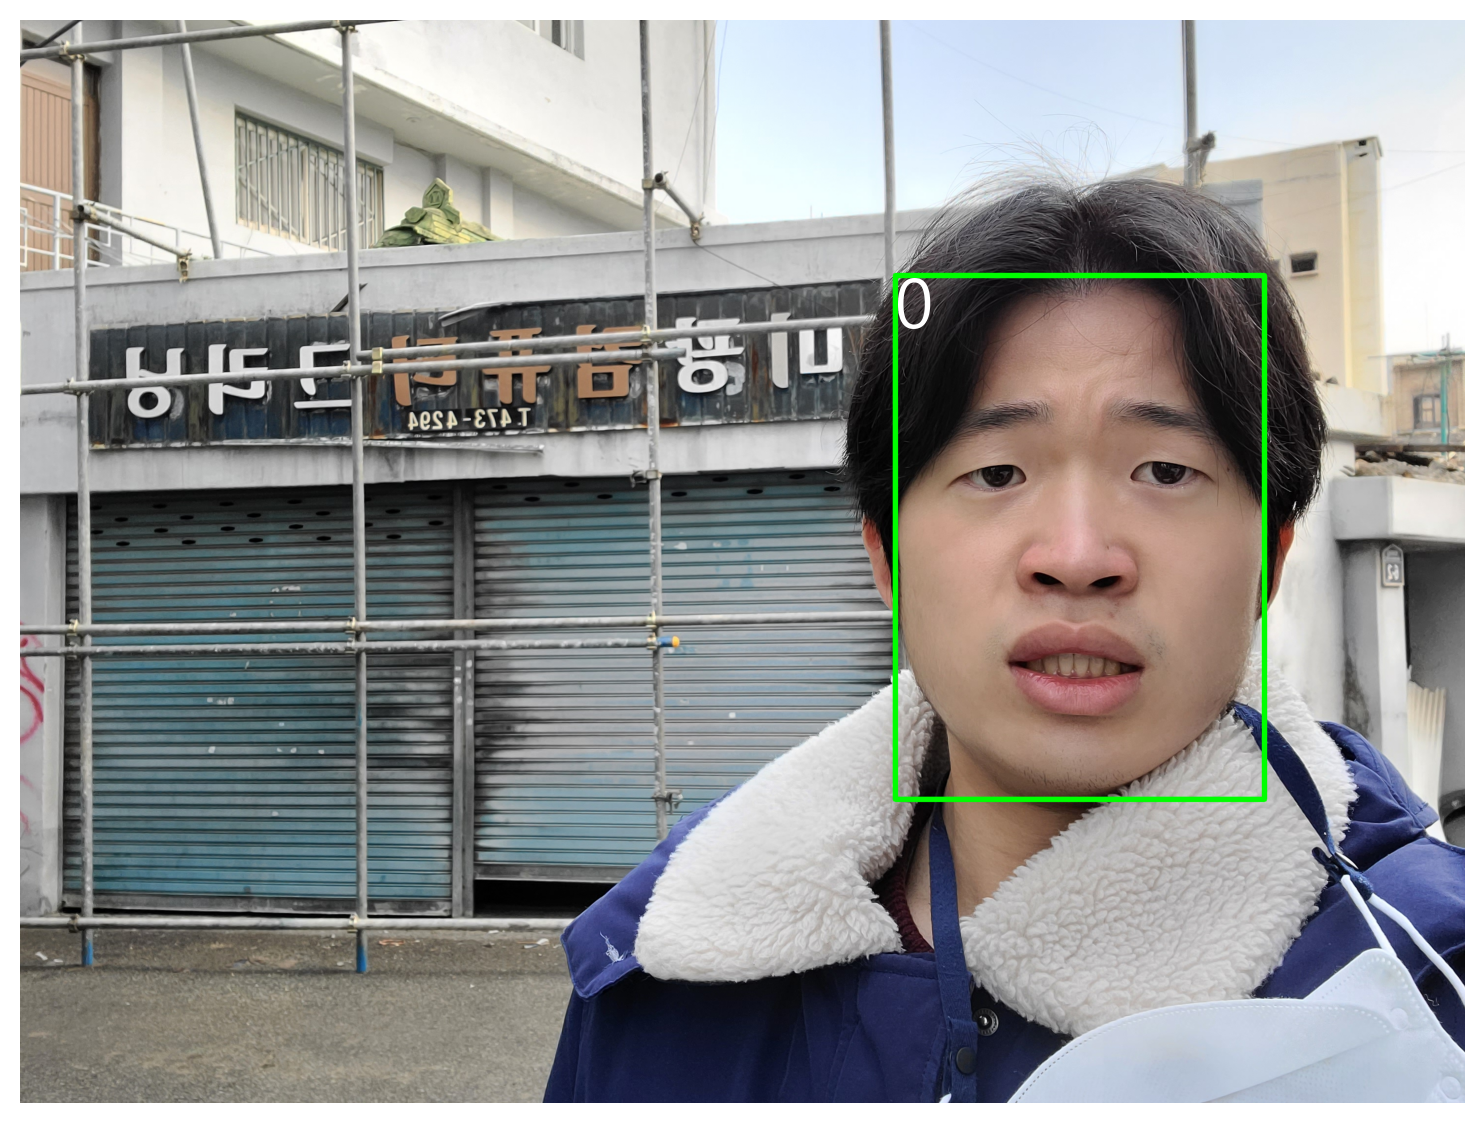

In [15]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def convert_yolo_to_bbox(image_size, yolo_bbox):
    """
    욜로 상대 좌표(점과 크기) 에서 절대 좌표로 변환
    """
    img_height, img_width = image_size
    x_center, y_center, width, height = yolo_bbox
    
    # Convert from relative coordinates to absolute coordinates
    x_center_abs = x_center * img_width
    y_center_abs = y_center * img_height
    width_abs = width * img_width
    height_abs = height * img_height
    
    # Calculate min and max coordinates
    minX = int(x_center_abs - (width_abs / 2.0))
    minY = int(y_center_abs - (height_abs / 2.0))
    maxX = int(x_center_abs + (width_abs / 2.0))
    maxY = int(y_center_abs + (height_abs / 2.0))
    
    return minX, minY, maxX, maxY

path_test_img = '../data/yolo_data/train/'
name = 'jwaccb50afa0212a340d07cd6204f4cd10aa5ab0b162c162a57f11431f7d3kdhp'
image = cv2.imread(path_test_img + name +'.jpg')
print(image)
h, w ,_ = image.shape
label_path = path_test_img + name + '.txt'
with open(label_path, 'r') as f:
    label__ =  f.read().split()

label__ = [float(i) for i in  label__]

recovered_pic_bb = convert_yolo_to_bbox((h,w),label__[1:])

minX, minY, maxX, maxY = recovered_pic_bb

image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
cv2.rectangle(image_rgb, (minX, minY), (maxX, maxY), (0, 255, 0), 10)
plt.axis('off')

plt.imshow(image_rgb)

plt.text(minX, minY, int(label__[0]), color='white', fontsize=25,
         ha='left', va='top')


plt.show()

### 모델 훈련 중 잘못된 음수 값

```text
train: WARNING ⚠️ /mnt/e/py_data/project_3_git/data/yolo_data/train/0xah1dfff2988dd0bb1002299e49a2e81221721df2086792404682f191894jnl2.jpg: ignoring corrupt image/label: negative label values [  -0.037574   -0.049603]
train: WARNING ⚠️ /mnt/e/py_data/project_3_git/data/yolo_data/train/xuiz83a96877b841898d16f32a9276e7a8d779d8d68f458e2816e296d6558w6em.jpg: ignoring corrupt image/label: negative label values [  -0.081222]
```

- 2개 데이터 포인트 이기 때문에 삭제 해도 무방하다고 판단.


https://github.com/MuhammadMoinFaisal/Computervisionprojects/blob/main/Train-Custom-YOLOv10/YOLOv10_Training_Custom_Dataset.zip

In [16]:
import urllib.request

url = "https://github.com/THU-MIG/yolov10/releases/download/v1.1/yolov10n.pt"

filename = os.path.basename(url)
filepath = os.path.join('yolov10n.pt')
urllib.request.urlretrieve(url, filepath)
print(f"Downloaded: {filepath}")

Downloaded: yolov10n.pt


In [17]:
!pip install --upgrade ultralytics torch
!pip install git+https://github.com/THU-MIG/yolov10.git
!pip cache purge

INFO: pip is looking at multiple versions of torchvision to determine which version is compatible with other requirements. This could take a while.
   ---------------------------------------- 0.0/872.0 kB ? eta -:--:--
   --------------------------------------- 872.0/872.0 kB 19.7 MB/s eta 0:00:00
   ---------------------------------------- 0.0/159.7 MB ? eta -:--:--
   - -------------------------------------- 5.5/159.7 MB 25.8 MB/s eta 0:00:06
   -- ------------------------------------- 11.0/159.7 MB 23.7 MB/s eta 0:00:07
   ---- ----------------------------------- 18.4/159.7 MB 26.9 MB/s eta 0:00:06
   ----- ---------------------------------- 23.3/159.7 MB 26.4 MB/s eta 0:00:06
   ------ --------------------------------- 25.2/159.7 MB 22.5 MB/s eta 0:00:06
   ------- -------------------------------- 29.6/159.7 MB 22.6 MB/s eta 0:00:06
   --------- ------------------------------ 36.7/159.7 MB 24.0 MB/s eta 0:00:06
   ----------- ---------------------------- 44.0/159.7 MB 26.7 MB/s eta

  You can safely remove it manually.
  You can safely remove it manually.


  Cloning https://github.com/THU-MIG/yolov10.git to c:\users\da317\appdata\local\temp\pip-req-build-jnny1oug
  Resolved https://github.com/THU-MIG/yolov10.git to commit cd2f79c70299c9041fb6d19617ef1296f47575b1
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with status 'done'
  Using cached thop-0.1.1.post2209072238-py3-none-any.whl.metadata (2.7 kB)
Using cached thop-0.1.1.post2209072238-py3-none-any.whl (15 kB)
  Created wheel for ultralytics: filename=ultralytics-8.1.34-py3-none-any.whl size=735413 sha256=c30af09bb334a015e017db3dbc396e7ed9c8d10cb26761a0c7e0f70b7d5d0e02
  Stored in directory: C:\Users\DA317\AppData\Local\Temp\pip-ephem-wheel-cache-yeij90wm\wheels\35\9a\d9\ec58d6096ceff21c4a77b18cd266af11385b347ca19a307597
Suc

  Running command git clone --filter=blob:none --quiet https://github.com/THU-MIG/yolov10.git 'C:\Users\DA317\AppData\Local\Temp\pip-req-build-jnny1oug'


Files removed: 108


In [18]:
!pip install huggingface_hub

In [36]:
import os 
print("Current Working directory: ", os.getcwd())

Current Working directory:  c:\Users\DA317\Desktop\Special course_Lee\240820(project)\project_3_git\code


In [48]:
from ultralytics.models import YOLOv10

model_for_trian = YOLOv10(filepath)
model_for_trian.train(data="../../project_3_git/data/yolo_data/wassup_data.yaml", epochs=10, imgsz=512)


New https://pypi.org/project/ultralytics/8.2.86 available 😃 Update with 'pip install -U ultralytics'
Ultralytics YOLOv8.1.34 🚀 Python-3.12.5 torch-2.3.1+cpu CPU (Intel Core(TM) i7-6700 3.40GHz)
engine\trainer: task=detect, mode=train, model=yolov10n.pt, data=../../project_3_git/data/yolo_data/wassup_data.yaml, epochs=10, time=None, patience=100, batch=16, imgsz=512, save=True, save_period=-1, val_period=1, cache=False, device=None, workers=8, project=None, name=train29, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, ret

100%|██████████| 755k/755k [00:00<00:00, 4.01MB/s]

Overriding model.yaml nc=80 with nc=4

                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      7360  ultralytics.nn.modules.block.C2f             [32, 32, 1, True]             
  3                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  4                  -1  2     49664  ultralytics.nn.modules.block.C2f             [64, 64, 2, True]             
  5                  -1  1      9856  ultralytics.nn.modules.block.SCDown          [64, 128, 3, 2]               


  6                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  7                  -1  1     36096  ultralytics.nn.modules.block.SCDown          [128, 256, 3, 2]              
  8                  -1  1    460288  ultralytics.nn.modules.block.C2f             [256, 256, 1, True]           
  9                  -1  1    164608  ultralytics.nn.modules.block.SPPF            [256, 256, 5]                 
 10                  -1  1    249728  ultralytics.nn.modules.block.PSA             [256, 256]                    
 11                  -1  1         0  torch.nn.modules.upsampling.Upsample         [None, 2, 'nearest']          
 12             [-1, 6]  1         0  ultralytics.nn.modules.conv.Concat           [1]                           
 13                  -1  1    148224  ultralytics.nn.modules.block.C2f             [384, 128, 1]                 
 14                  -1  1         0  torch.nn.modules.upsampling.Upsample         [None

train: Scanning C:\Users\DA317\Desktop\Special course_Lee\240820(project)\project_3_git\data\yolo_data\train... 5992 images, 2 backgrounds, 0 corrupt: 100%|██████████| 5994/5994 [00:08<00:00, 710.32it/s]


train: New cache created: C:\Users\DA317\Desktop\Special course_Lee\240820(project)\project_3_git\data\yolo_data\train.cache


val: Scanning C:\Users\DA317\Desktop\Special course_Lee\240820(project)\project_3_git\data\yolo_data\val... 1199 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1199/1199 [00:01<00:00, 709.89it/s]


val: New cache created: C:\Users\DA317\Desktop\Special course_Lee\240820(project)\project_3_git\data\yolo_data\val.cache
Plotting labels to runs\detect\train29\labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.00125, momentum=0.9) with parameter groups 95 weight(decay=0.0), 108 weight(decay=0.0005), 107 bias(decay=0.0)
Image sizes 512 train, 512 val
Using 0 dataloader workers
Logging results to runs\detect\train29
Starting training for 10 epochs...
Closing dataloader mosaic

      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


       1/10         0G     0.7601      2.073     0.9919     0.7541      5.513      0.969         10        512: 100%|██████████| 375/375 [1:05:36<00:00, 10.50s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [04:39<00:00,  7.36s/it]


                   all       1199       1199      0.568      0.676      0.568      0.466

      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


       2/10         0G     0.7048      1.201     0.9161     0.7417      2.162     0.9111         10        512: 100%|██████████| 375/375 [49:31<00:00,  7.92s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [04:21<00:00,  6.89s/it]


                   all       1199       1199      0.507      0.713      0.622      0.513

      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


       3/10         0G     0.6835     0.9537     0.9039     0.7194      1.168     0.9019         10        512: 100%|██████████| 375/375 [48:41<00:00,  7.79s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [04:19<00:00,  6.84s/it]


                   all       1199       1199      0.735       0.74      0.767      0.641

      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


       4/10         0G     0.6585     0.8399     0.8982     0.6898     0.9113     0.8953         10        512: 100%|██████████| 375/375 [48:31<00:00,  7.76s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [04:19<00:00,  6.84s/it]


                   all       1199       1199      0.639      0.739      0.748       0.64

      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


       5/10         0G     0.6474     0.7852     0.8927     0.6782     0.8043     0.8894         10        512: 100%|██████████| 375/375 [48:47<00:00,  7.81s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [04:19<00:00,  6.84s/it]


                   all       1199       1199       0.72      0.782      0.815      0.692

      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


       6/10         0G     0.6317     0.7212     0.8899     0.6559     0.7198     0.8857         10        512: 100%|██████████| 375/375 [48:30<00:00,  7.76s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [04:19<00:00,  6.83s/it]


                   all       1199       1199      0.773      0.787      0.843      0.718

      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


       7/10         0G      0.625     0.6781     0.8837     0.6469      0.666     0.8764         10        512: 100%|██████████| 375/375 [49:16<00:00,  7.88s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [04:24<00:00,  6.95s/it]


                   all       1199       1199      0.782      0.788      0.864      0.738

      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


       8/10         0G     0.6062     0.6379     0.8829     0.6215     0.6188     0.8772         10        512: 100%|██████████| 375/375 [54:33<00:00,  8.73s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [05:01<00:00,  7.93s/it]


                   all       1199       1199      0.778      0.802      0.863      0.738

      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


       9/10         0G     0.5939     0.5807     0.8768     0.6082     0.5614     0.8686         10        512: 100%|██████████| 375/375 [51:47<00:00,  8.29s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [04:37<00:00,  7.31s/it]


                   all       1199       1199       0.78      0.813      0.872      0.749

      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


      10/10         0G     0.5785     0.5491     0.8681     0.5897     0.5329       0.86         10        512: 100%|██████████| 375/375 [52:40<00:00,  8.43s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [04:42<00:00,  7.43s/it]


                   all       1199       1199      0.801      0.804      0.876      0.759

10 epochs completed in 9.387 hours.
Optimizer stripped from runs\detect\train29\weights\last.pt, 5.7MB
Optimizer stripped from runs\detect\train29\weights\best.pt, 5.7MB

Validating runs\detect\train29\weights\best.pt...
Ultralytics YOLOv8.1.34 🚀 Python-3.12.5 torch-2.3.1+cpu CPU (Intel Core(TM) i7-6700 3.40GHz)
YOLOv10n summary (fused): 285 layers, 2695976 parameters, 0 gradients, 8.2 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [04:16<00:00,  6.74s/it]


                   all       1199       1199      0.801      0.804      0.876      0.759
                 anger       1199        300      0.652       0.83      0.817      0.708
                   sad       1199        300      0.841       0.72      0.889      0.764
                 panic       1199        300      0.769      0.753      0.831      0.713
                 happy       1199        299      0.941      0.911      0.969      0.848
Speed: 1.5ms preprocess, 89.2ms inference, 0.0ms loss, 0.2ms postprocess per image
Results saved to runs\detect\train29


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1, 2, 3])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x000001BD31C12600>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
       

In [55]:
# 훈련된 모델 불러오기

model_transfered = YOLOv10('../runs/detect/train29/weights/best.pt')
test_image = cv2.imread('../ssg.jpg')
model_transfered(test_image)[0].show()


0: 512x352 1 anger, 1 panic, 205.5ms
Speed: 4.0ms preprocess, 205.5ms inference, 1.0ms postprocess per image at shape (1, 3, 512, 352)
